먼저 필요한 파일을 만들어주자.

In [2]:
if not os.path.exists('./images_and_labels'): os.makedirs('./images_and_labels')                # images, labels 파일을 담을 파일
if not os.path.exists('./images_and_labels/images'): os.makedirs('./images_and_labels/images')  # train, test 이미지를 저장할 파일
if not os.path.exists('./images_and_labels/labels'): os.makedirs('./images_and_labels/labels')  # train, test의 라벨을 저장할 파일

먼저 train 이미지를 불러오고 text label을 만들어준다. <br>
아래 코드는 train 이미지들의 label을 만들어주는 코드다.

In [1]:
import json
import os

with open("../detection/dataset/train.json", "r") as json_file: # label이 저장된 train.json 파일을 가져온다.
    train_json = json.load(json_file)

ann_index = 0; img_index = 0                                    # 탐색할 annotation, image에 대한 인덱스이다. image의 인덱스란 이미지의 번호를 의미한다. (0100의 경우 100이다.)
txt_path = './images_and_labels/labels'

while img_index < 4883:                                         # BBox가 저장된 모든 annotation을 탐색한다.
    image_id = str(img_index)                                   # 이미지 번호를 형식에 맞게 저장한다. (0은 '0000', 1은 '0001' 식으로 변경)
    while len(image_id)<4: image_id = '0'+image_id
    txt_file = open(os.path.join(txt_path, image_id+'.txt'), 'w')

    string = ''
    while ann_index < len(train_json['annotations']):
        annotation = train_json['annotations'][ann_index]
        if img_index != annotation['image_id']:                 # 현재 탐색하고 있는 이미지와 id가 일치하는지 확인하고 일치하지 않으면 반복문을 탈출한다. 
            break                       
        
        category = annotation['category_id']                    # category_id(class number)를 가져온다.
        coco_x, coco_y, coco_w, coco_h = annotation['bbox']     # bbox를 가져온다. (coco dataset)
        yolo_x = (coco_x+coco_w/2)/1024                         # yolo dataset 형식으로 바꿔준다.
        yolo_y = (coco_y+coco_h/2)/1024
        yolo_w = coco_w/1024
        yolo_h = coco_h/1024
        
        string += f'{category} {yolo_x:.6} {yolo_y:.6} {yolo_w:.6} {yolo_h:.6}\n'
        ann_index += 1
    txt_file.write(string.rstrip())
    txt_file.close()
    img_index += 1

그리고 학습한 모델에 test 이미지를 추론시키고, 추론된 label이 담긴 txt 파일들을 현재 labels파일에 옮긴다. <br>
test 이미지도 images 파일에 모두 옮겨야 한다.

* python detect.py --img 1024 --source './data/test' --weights './runs/train/YoloV5x_label_smoothing_Hyp_tuning/weights/best.pt' --save-txt --name YoloV5x_label_smoothing_Hyp_tuning_IOU --augment --iou-thres 0.5

아래는 test 이미지들을 저장하는 코드다. (약 5분 소요)

In [6]:
import numpy as np
import os
from PIL import Image

imgs_path = './../detection/dataset/test'                       # 이미지 파일에 접근하기 위해 train_image가 저장된 path를 지정해 놓는다.
image_id = 4883                                                 # 위에서 train image들을 저장할 때 마지막 image의 id가 4882이므로 test이미지를 저장할 때는 4883으로 시작해야 한다.

for test_idx in range(4871):
    test_id = str(test_idx)
    save_id = str(test_idx+image_id)
    while len(test_id)<4: test_id = '0'+test_id 

    save_path = './images_and_labels/images'                    # 이미지를 저장할 폴더를 지정한다.
    img = Image.open(os.path.join(imgs_path, test_id+'.jpg'))   # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, save_id+'.jpg'), 'JPEG') 
    
print('Complete Download Test Images')

Complete Download Test Images


아래는 test이미지들의 label을 가져오는 코드다.

In [9]:
label_path = '../yolov5/runs/detect/Labeling_File/labels'           # 라벨이 존재하는 폴더를 지정한다.
save_path = './images_and_labels/labels'                            # 라벨을 저장할 폴더를 지정한다.

image_id = 4883                                                     # 위에서 train image들을 저장할 때 마지막 image의 id가 4882이므로 test이미지를 저장할 때는 4883으로 시작해야 한다.
for test_idx in range(4871):
    test_id = str(test_idx)
    save_id = str(test_idx+image_id)
    while len(test_id)<4: test_id = '0'+test_id 
    try:
        txt_file = open(os.path.join(label_path, test_id+'.txt'), 'r')   # 라벨을 가져온다.
        lines = txt_file.readlines()
        txt_file.close()
    except:
        lines = ''
    txt_file = open(os.path.join(save_path, save_id+'.txt'), 'w')
    txt_file.write(''.join(lines))
    txt_file.close()

이후 모인 train, test 이미지를 train, valid 셋으로 나눠준다. <br>
먼저 필요한 파일들을 생성하자.

In [10]:
if not os.path.exists('./train'): os.makedirs('./train')                # train images, labels 파일을 담을 파일
if not os.path.exists('./train/images'): os.makedirs('./train/images')  
if not os.path.exists('./train/labels'): os.makedirs('./train/labels')  
if not os.path.exists('./valid'): os.makedirs('./valid')                # valid images, labels 파일을 담을 파일
if not os.path.exists('./valid/images'): os.makedirs('./valid/images')  
if not os.path.exists('./valid/labels'): os.makedirs('./valid/labels')  

In [11]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from PIL import Image

imgs = [str(i) for i in range(9754)]                            # 이미지들에 접근하기 위해 형태에 맞게 이미지 번호를 저장한다. (index->0~9753)
for i in range(len(imgs)):
    while len(imgs[i])<4: imgs[i] = '0'+imgs[i] 

np.random.seed(777)                                             # random seed를 고정한다.
np.random.shuffle(imgs)                                         # 이미지 번호를 섞어준다.

train_imgs, valid_imgs = train_test_split(imgs, test_size=0.2)  # random seed는 위에서 지정했으므로 지정하지 않아도 된다.
train_imgs.sort()                                               
valid_imgs.sort()

imgs_path = './images_and_labels/images'                        # 이미지 파일에 접근하기 image가 저장된 path를 지정해 놓는다.

print(f'train imgs 개수: {len(train_imgs)} / valid imgs 개수: {len(valid_imgs)}')

for train_img in train_imgs:
    save_path = './train/images'                                # 이미지를 저장할 폴더를 지정한다.
    if not os.path.exists(save_path): os.makedirs(save_path)    # 해당 폴더가 없으면 생성한다.
    img = Image.open(os.path.join(imgs_path, train_img+'.jpg')) # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, train_img+'.jpg'), 'JPEG') 

print('Complete Download Train Images')
    
for valid_img in valid_imgs:
    save_path = './valid/images'                                # 이미지를 저장할 폴더를 지정한다.
    if not os.path.exists(save_path): os.makedirs(save_path)    # 해당 폴더가 없으면 생성한다.
    img = Image.open(os.path.join(imgs_path, valid_img+'.jpg')) # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, valid_img+'.jpg'), 'JPEG')
    
print('Complete Download Valid Images')

train imgs 개수: 7803 / valid imgs 개수: 1951
Complete Download Train Images
Complete Download Valid Images


In [12]:
import shutil

labels_path = './images_and_labels/labels'                         

for train_img in train_imgs:
    save_path = './train/labels'                                    
    if not os.path.exists(save_path): os.makedirs(save_path)        
    shutil.copy(os.path.join(labels_path, train_img+'.txt'), save_path)     

print('Complete Download Train Labels')
    
for valid_img in valid_imgs:
    save_path = './valid/labels'                                    
    if not os.path.exists(save_path): os.makedirs(save_path)        
    shutil.copy(os.path.join(labels_path, valid_img+'.txt'), save_path)  
    
print('Complete Download Valid Labels')

Complete Download Train Labels
Complete Download Valid Labels


train, valid의 label 분포를 확인해보자. <br>
어느 정도 비슷한 분포를 가지는 것을 확인할 수 있다.

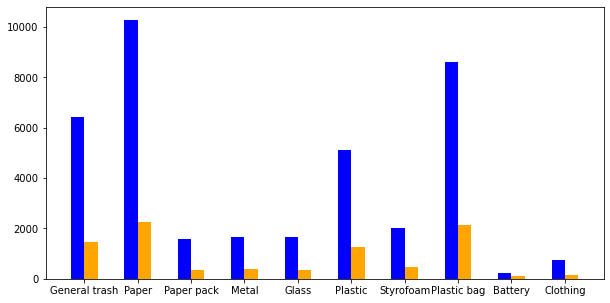

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

imgs = [str(i) for i in range(9754)]                            
for i in range(len(imgs)):
    while len(imgs[i])<4: imgs[i] = '0'+imgs[i] 


train_txts_path = './train/labels'
valid_txts_path = './valid/labels'

train_images = [0 for _ in range(10)]
valid_images = [0 for _ in range(10)]


for img in imgs:
    txt_path = os.path.join(train_txts_path, img+'.txt')
    if not os.path.exists(txt_path):
        continue
    txt_file = open(txt_path, 'r')
    lines = txt_file.readlines()
    
    for line in lines:
        category, x, y, w, h = line.split()
        train_images[int(category)] += 1
    
    txt_file.close()

for img in imgs:
    txt_path = os.path.join(valid_txts_path, img+'.txt')
    if not os.path.exists(txt_path):
        continue
    txt_file = open(txt_path, 'r')
    lines = txt_file.readlines()
    
    for line in lines:
        category, x, y, w, h = line.split()
        valid_images[int(category)] += 1
    
    txt_file.close()

plt.figure(figsize=(10,5))
index = np.arange(10)
plt.bar(index-0.125, train_images, width=0.25, color='blue')
plt.bar(index+0.125, valid_images, width=0.25, color='orange')
plt.xticks(index, ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing'])
plt.show()

이후 해당 파일들을 yolov5에 넘겨주면 된다.